# Working with Parcels output


This tutorial covers the format of the trajectory output exported by Parcels. **Parcels does not include advanced analysis or plotting functionality**, which users are suggested to write themselves to suit their research goals. Here we provide some starting points to explore the parcels output files yourself.

- [**Reading the output file**](#Reading-the-output-file)
- [**Trajectory data structure**](#Trajectory-data-structure)
- [**Analysis**](#Analysis)
- [**Plotting**](#Plotting)
- [**Animations**](#Animations)

First we need to create some parcels output to analyse. We simulate a set of particles using the setup described in the [Delay start tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_delaystart.html).


In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, download_example_dataset
from parcels import AdvectionRK4
import numpy as np
from datetime import timedelta as delta

In [2]:
example_dataset_folder = download_example_dataset("Peninsula_data")
fieldset = FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula", allow_time_extrapolation=True
)

npart = 10  # number of particles to be released
lon = 3e3 * np.ones(npart)
lat = np.linspace(3e3, 45e3, npart, dtype=np.float32)

# release every particle two hours later
time = np.arange(npart) * delta(hours=2).total_seconds()

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)

output_file = pset.ParticleFile(name="Output.zarr", outputdt=delta(hours=2))
pset.execute(
    AdvectionRK4, runtime=delta(hours=24), dt=delta(minutes=5), output_file=output_file
)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib088fa921801c32f8e36f744a9a505a1f_0.so


## Reading the output file

Parcels exports output trajectories in `zarr` [format](https://zarr.readthedocs.io/en/stable/). Files in `zarr` are typically _much_ smaller in size than netcdf, although may be slightly more challenging to handle (but `xarray` has a fairly seamless `open_zarr()` method).


In [3]:
import xarray as xr

data_xarray = xr.open_zarr("Output.zarr")
print(data_xarray)

<xarray.Dataset>
Dimensions:     (trajectory: 10, obs: 13)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    lat         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           flat
    parcels_version:        v2.4.2-43-gc244f072


In [4]:
print(data_xarray["trajectory"])

<xarray.DataArray 'trajectory' (trajectory: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 7 8 9


Note that if you are running Parcels on multiple processors with `mpirun`, you will need to concatenate the files of each processor, see also the [MPI documentation](https://docs.oceanparcels.org/en/latest/examples/documentation_MPI.html#Reading-in-the-ParticleFile-data-in-zarr-format).

Also, once you have loaded the data as an `xarray` DataSet using `xr.open_zarr()`, you can always save the file to NetCDF if you prefer with the `.to_netcdf()` method.


## Trajectory data structure

The data zarr file are organised according to the [CF-conventions](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html#discrete-sampling-geometries) implemented with the [NCEI trajectory template](https://www.nodc.noaa.gov/data/formats/netcdf/v2.0/trajectoryIncomplete.cdl). The data is stored in a **two-dimensional array** with the dimensions **`traj`** and **`obs`**. Each particle trajectory is essentially stored as a time series where the coordinate data (**`lon`**, **`lat`**, **`time`**) are a function of the observation (`obs`).

The output dataset used here contains **10 particles** and **13 observations**. Not every particle has 13 observations however; since we released particles at different times some particle trajectories are shorter than others.


In [5]:
np.set_printoptions(linewidth=160)
ns_per_hour = np.timedelta64(1, "h")  # nanoseconds in an hour

print(data_xarray["time"].data / ns_per_hour)  # time is stored in nanoseconds

dask.array<truediv, shape=(10, 13), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>


Note how the first observation occurs at a different time for each trajectory. **`obs` != `time`**


## Analysis

Sometimes, trajectories are analysed as they are stored: as individual time series. If we want to study the distance travelled as a function of time, the time we are interested in is the time relative to the start of the each particular trajectory: the array operations are simple since each trajectory is analysed as a function of **`obs`**. The time variable is only needed to express the results in the correct units.


In [6]:
import matplotlib.pyplot as plt

x = data_xarray["lon"].values
y = data_xarray["lat"].values
distance = np.cumsum(
    np.sqrt(np.square(np.diff(x)) + np.square(np.diff(y))), axis=1
)  # d = (dx^2 + dy^2)^(1/2)

real_time = data_xarray["time"] / ns_per_hour  # convert time to hours
time_since_release = (
    real_time.values.transpose() - real_time.values[:, 0]
)  # substract the initial time from each timeseries

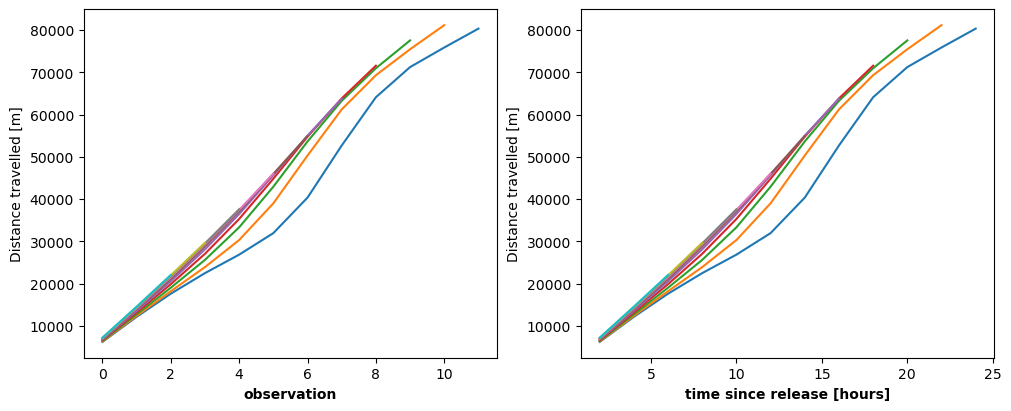

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

ax1.set_ylabel("Distance travelled [m]")
ax1.set_xlabel("observation", weight="bold")
d_plot = ax1.plot(distance.transpose())

ax2.set_ylabel("Distance travelled [m]")
ax2.set_xlabel("time since release [hours]", weight="bold")
d_plot_t = ax2.plot(time_since_release[1:], distance.transpose())
plt.show()

The two figures above show the same graph. Time is not needed to create the first figure. The time variable minus the first value of each trajectory gives the x-axis the correct units in the second figure.

We can also plot the distance travelled as a function of the absolute time easily, since the `time` variable matches up with the data for each individual trajectory.


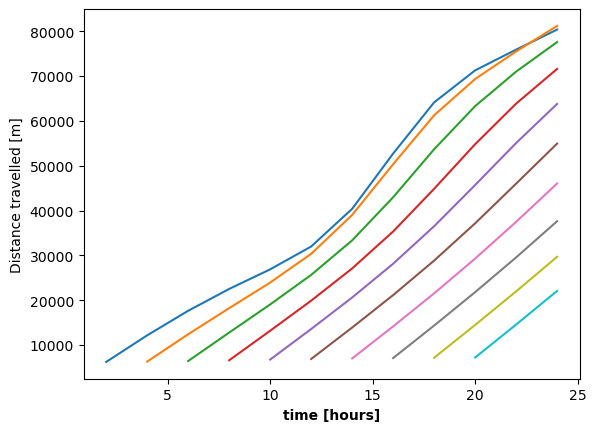

In [8]:
plt.figure()
ax = plt.axes()
ax.set_ylabel("Distance travelled [m]")
ax.set_xlabel("time [hours]", weight="bold")
d_plot_t = ax.plot(real_time.T[1:], distance.transpose())

### Conditional selection

In other cases, the processing of the data itself however depends on the absolute time at which the observations are made, e.g. studying seasonal phenomena. In that case the array structure is not as simple: the data must be selected by their `time` value. Here we show how the mean location of the particles evolves through time. This also requires the trajectory data to be aligned in time. The data are selected using `xr.DataArray.where()` which compares the time variable to a specific time. This type of selecting data with a condition (`data_xarray['time']==time`) is a powerful tool to analyze trajectory data.


In [9]:
# Using xarray
mean_lon_x = []
mean_lat_x = []

timerange = np.arange(
    np.nanmin(data_xarray["time"].values),
    np.nanmax(data_xarray["time"].values) + np.timedelta64(delta(hours=2)),
    delta(hours=2),
)  # timerange in nanoseconds

for time in timerange:
    if np.all(
        np.any(data_xarray["time"] == time, axis=1)
    ):  # if all trajectories share an observation at time
        mean_lon_x += [
            np.nanmean(data_xarray["lon"].where(data_xarray["time"] == time).values)
        ]  # find the data that share the time
        mean_lat_x += [
            np.nanmean(data_xarray["lat"].where(data_xarray["time"] == time).values)
        ]  # find the data that share the time

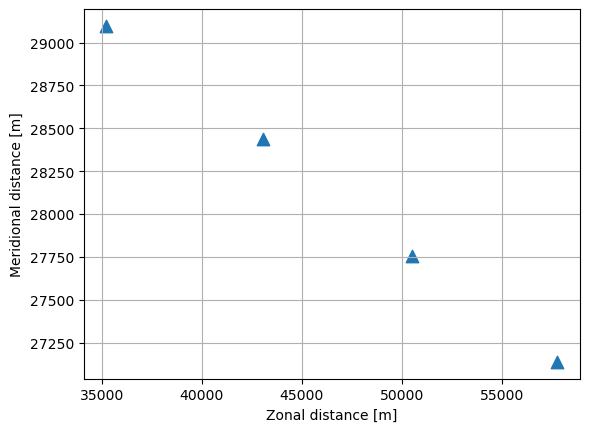

In [10]:
plt.figure()
ax = plt.axes()
ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.grid()
ax.scatter(mean_lon_x, mean_lat_x, marker="^", s=80)
plt.show()

## Plotting

Parcels output consists of particle trajectories through time and space. An important way to explore patterns in this information is to draw the trajectories in space. Parcels provides the `ParticleSet.show()` method and the `plotTrajectoryFile` script to quickly plot at results, but users are encouraged to create their own figures, for example by using the comprehensive [**matplotlib**](https://matplotlib.org/) library. Here we show a basic setup on how to process the parcels output into trajectory plots and animations.

Some other packages to help you make beautiful figures are:

- [**cartopy**](https://scitools.org.uk/cartopy/docs/latest/), a map-drawing tool especially compatible with matplotlib
- [**cmocean**](https://matplotlib.org/cmocean/), a set of beautiful colormaps


To draw the trajectory data in space usually it is informative to draw points at the observed coordinates to see the resolution of the output and draw a line through them to separate the different trajectories. The coordinates to draw are in `lon` and `lat` and can be passed to either `matplotlib.pyplot.plot` or `matplotlib.pyplot.scatter`. Note however, that the default way matplotlib plots 2D arrays is to plot a separate set for each column. In the parcels 2D output, the columns correspond to the `obs` dimension, so to separate the different trajectories we need to transpose the 2D array using `.T`.


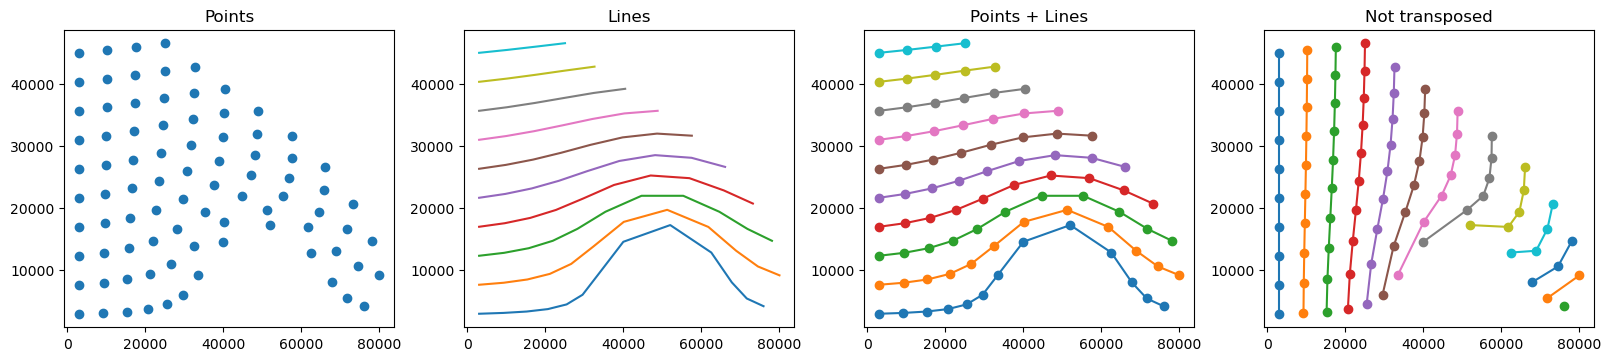

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    1, 4, figsize=(16, 3.5), constrained_layout=True
)

###-Points-###
ax1.set_title("Points")
ax1.scatter(data_xarray["lon"].T, data_xarray["lat"].T)
###-Lines-###
ax2.set_title("Lines")
ax2.plot(data_xarray["lon"].T, data_xarray["lat"].T)
###-Points + Lines-###
ax3.set_title("Points + Lines")
ax3.plot(data_xarray["lon"].T, data_xarray["lat"].T, marker="o")
###-Not Transposed-###
ax4.set_title("Not transposed")
ax4.plot(data_xarray["lon"], data_xarray["lat"], marker="o")

plt.show()

### Animations


Trajectory plots like the ones above can become very cluttered for large sets of particles. To better see patterns, it's a good idea to create an animation in time and space. To do this, matplotlib offers an [animation package](https://matplotlib.org/3.3.2/api/animation_api.html). Here we show how to use the [`FuncAnimation`](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation) class to animate parcels trajectory data.

To correctly reveal the patterns in time we must remember that [the `obs` dimension does not necessarily correspond to the `time` variable](#Trajectory-data-structure). In the animation of the particles, we usually want to draw the points at each consecutive moment in time, not necessarily at each moment since the start of the trajectory. To do this we must [select the correct data](#Conditional-selection) in each rendering.


In [12]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

outputdt = delta(hours=2)

# timerange in nanoseconds
timerange = np.arange(
    np.nanmin(data_xarray["time"].values),
    np.nanmax(data_xarray["time"].values) + np.timedelta64(outputdt),
    outputdt,
)

In [13]:
%%capture
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 90000)
ax.set_ylim(0, 50000)
plt.xticks(rotation=45)

# Indices of the data where time = 0
time_id = np.where(data_xarray["time"] == timerange[0])

scatter = ax.scatter(
    data_xarray["lon"].values[time_id], data_xarray["lat"].values[time_id]
)

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title("Particles at t = " + t)


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text("Particles at t = " + t)

    time_id = np.where(data_xarray["time"] == timerange[i])
    scatter.set_offsets(
        np.c_[data_xarray["lon"].values[time_id], data_xarray["lat"].values[time_id]]
    )


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=500)

In [14]:
HTML(anim.to_jshtml())